In [1]:
# import libraries
import torch
import numpy as np
from dataloader import get_dataloader_vae
from dataloader import get_dataloader_OOD
from models import get_trained_model
from torch.distributions.multivariate_normal import MultivariateNormal
#from energy import ELOOD
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class for energy-like ood detection
class ELOOD:
    def __init__(self, model, T=10000):
        self.model = model.to(device)
        
    # get reconstruction term of energy per sample
    def get_recon_energy(self, input, output):
        '''
        # Construct the multivariate Gaussian distribution
        sigma = torch.exp(0.5 * logvar)
        mvn = MultivariateNormal(mu, torch.diag_embed(sigma))

        log_prob = mvn.log_prob(z)

        return -log_prob
        '''
        result = (output - input).pow(2).sum()
        return result


    # get ood scores 
    def get_scores(self, loader):
        ood_scores = []
        for i, (images, _) in enumerate(loader):
            images = images.to(device)
            
            # get reconstructed, mu, logvar, latent space representation
            reconstructed, mu, logvar, z = self.model(images)

            '''
            # convert tensors to numpy
            images = images.detach().cpu().data.numpy()
            reconstructed = reconstructed.detach().cpu().data.numpy()
            mu = mu.detach().cpu().data.numpy()
            logvar = logvar.detach().cpu().data.numpy()
            z = z.detach().cpu().data.numpy()
            '''


            # get reconstruction term of energy
            recon_energy = torch.zeros((images.shape[0]))
            for i in range(images.shape[0]):
                recon_energy[i] = self.get_recon_energy(images[i], reconstructed[i])
            
            kld = torch.zeros((images.shape[0]))
            for i in range(images.shape[0]):
                kld[i] = - 0.5 * (1 + logvar[i] - mu[i].pow(2) - logvar[i].exp()).sum()

            # get KL divergence term of energy
            #kld = -0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1)

            scores = recon_energy.cpu().data.numpy() + kld.cpu().data.numpy()
            
            ood_scores.extend(scores) 
        
        return ood_scores

In [3]:
model = get_trained_model('CIFAR10')
# get dataloaders
train_dl, test_dl = get_dataloader_vae('CIFAR10')
svhn_dl = get_dataloader_OOD('SVHN')
det = ELOOD(model)

Files already downloaded and verified
Using downloaded and verified file: data\test_32x32.mat


In [4]:
print("for c10")
c10 = det.get_scores(train_dl)
print("for svhn")
sv = det.get_scores(svhn_dl)

for c10
for svhn


In [5]:
len(c10), len(sv)

(50000, 26032)

In [6]:
def statdesc(data):
    ## Statistical Descriptors

    # Mean
    mean = np.mean(data)
    print(f"Mean: {mean}")

    # Median
    median = np.median(data)
    print(f"Median: {median}")

    # Standard Deviation
    std_dev = np.std(data)
    print(f"Standard Deviation: {std_dev}")

    # Quartiles
    quartiles = np.quantile(data, [0.25, 0.5, 0.75])
    print(f"Quartiles: {quartiles}")

    # Interquartile Range (IQR)
    iqr = quartiles[2] - quartiles[0]
    print(f"Interquartile Range (IQR): {iqr}")

    # Minimum and Maximum
    data_min = np.min(data)
    data_max = np.max(data)
    print(f"Minimum: {data_min}")
    print(f"Maximum: {data_max}")

In [7]:
statdesc(c10)
print()
statdesc(sv)

Mean: 1859.1500244140625
Median: 1655.62548828125
Standard Deviation: 1097.48193359375
Quartiles: [1078.91098022 1655.62542725 2391.99157715]
Interquartile Range (IQR): 1313.0805969238281
Minimum: 91.24855041503906
Maximum: 10028.908203125

Mean: 1557.3984375
Median: 1011.8973388671875
Standard Deviation: 1468.72705078125
Quartiles: [ 428.51101685 1011.89733887 2266.55889893]
Interquartile Range (IQR): 1838.0478820800781
Minimum: 74.64643096923828
Maximum: 8521.876953125


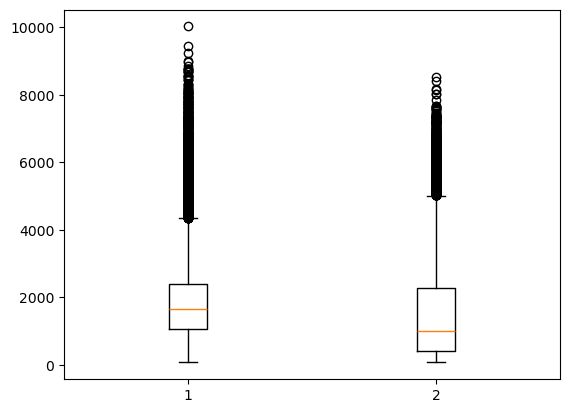

In [8]:
# Plot
plt.boxplot([c10, sv])

# Display the plot
plt.show()